# 项目文档 Project Documentation
Predicting T-Cell Receptor
Specificity
## 概述 summarize

AUTHOR: Renjie Zhou......

本文档在于提供miniproject problem A 的解决方案之一

This document is intended to provide one of the solutions to miniproject problem A.
### DISTANCE-BASED TCR ANALYSIS

In [118]:
import pandas as pd
import matplotlib.pyplot as plt
import umap

### 导入数据 Import data

In [119]:
raw_data = pd.read_csv("vdjdb.txt",sep='\t')
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92771 entries, 0 to 92770
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   complex.id        92771 non-null  int64 
 1   gene              92771 non-null  object
 2   cdr3              92771 non-null  object
 3   v.segm            92670 non-null  object
 4   j.segm            91626 non-null  object
 5   species           92771 non-null  object
 6   mhc.a             92771 non-null  object
 7   mhc.b             92771 non-null  object
 8   mhc.class         92771 non-null  object
 9   antigen.epitope   92771 non-null  object
 10  antigen.gene      92709 non-null  object
 11  antigen.species   92771 non-null  object
 12  reference.id      91260 non-null  object
 13  method            92771 non-null  object
 14  meta              92771 non-null  object
 15  cdr3fix           92771 non-null  object
 16  vdjdb.score       92771 non-null  int64 
 17  web.method  

### 检查VDJdb.score为0的数据，删除score为0的数据

Check the data where VDJdb.score is 0 and delete the data where score is 0

In [120]:
# 检查vdjdb score为0的数据数量
# Check the number of data with a vdjdb score of 0
zero_score_count = len(raw_data[raw_data['vdjdb.score'] == 0])
print("The number of 0 score is : ", zero_score_count)

The number of 0 score is :  80357


In [121]:
# 删除VDJdb.score为0的数据, 因为score为0时没有足够证据表明tcr特异性
# Remove data with a VDJdb.score of 0, as there is insufficient evidence of tcr specificity when the score is 0.
df = raw_data[raw_data['vdjdb.score'] != 0]
# df = raw_data
remain_count = len(df)
print("remain number(after remove score = 0 ) is : ", remain_count)

remain number(after remove score = 0 ) is :  12414


### 保留重要的特征 Retain important features

In [122]:
df = df.loc[:, ['complex.id','cdr3', 'v.segm', 'j.segm', 'gene', 'antigen.epitope', 'species']]

### 删除空值 Deleting null values

In [123]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12156 entries, 0 to 92768
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   complex.id       12156 non-null  int64 
 1   cdr3             12156 non-null  object
 2   v.segm           12156 non-null  object
 3   j.segm           12156 non-null  object
 4   gene             12156 non-null  object
 5   antigen.epitope  12156 non-null  object
 6   species          12156 non-null  object
dtypes: int64(1), object(6)
memory usage: 759.8+ KB


#### 按species分割成三个子数据集（人类，老鼠，猴子）

Split into three sub-datasets by SPECIES (human, mouse, monkey)

In [124]:
df['species'].unique()

grouped = df.groupby('species')
homo_df = None
mus_df = None
macaca_df = None

for species, group in grouped:
    if species == 'HomoSapiens': # human
        homo_df = group
    elif species == 'MusMusculus': # mouse
        mus_df = group
    elif species == 'MacacaMulatta': # monkey
        macaca_df = group

# just focus on human dataset
homo_df.head()

,complex.id,cdr3,v.segm,j.segm,gene,antigen.epitope,species
0,1,CIVRAPGRADMRF,TRAV26-1*01,TRAJ43*01,TRA,FLKEKGGL,HomoSapiens
1,1,CASSYLPGQGDHYSNQPQHF,TRBV13*01,TRBJ1-5*01,TRB,FLKEKGGL,HomoSapiens
2,0,CASSFEAGQGFFSNQPQHF,TRBV13*01,TRBJ1-5*01,TRB,FLKEKGGL,HomoSapiens
3,2,CAVPSGAGSYQLTF,TRAV20*01,TRAJ28*01,TRA,FLKEKGGL,HomoSapiens
4,2,CASSFEPGQGFYSNQPQHF,TRBV13*01,TRBJ1-5*01,TRB,FLKEKGGL,HomoSapiens


### 分离α链、β链、配对的α-β链(人类)

Separation of alpha chain, beta chain, paired alpha-beta chain (human)

homo_df_alpha:Data for the alpha chain is saved $\newline$
homo_df_beta:Data from the beta chain is saved $\newline$
homo_df_paired:Data for paired alpha and beta strands are preserved

In [125]:
homo_df_alpha = homo_df[homo_df['gene'] == 'TRA']
homo_df_beta = homo_df[homo_df['gene'] == 'TRB']
print("The number of homo_df is ",homo_df.shape[0])# human dataset
print("The number of homo_df_alpha is ",homo_df_alpha.shape[0])# human alpha dataset
print("The number of homo_df_beta is ",homo_df_beta.shape[0])# human beta dataset
# Filtering out records that are not 0
paired_data = homo_df[homo_df['complex.id'] != 0]
# Creating an empty dataframe
homo_df_paired = pd.DataFrame
# For each different complex.id pull the data into a    new data box
merged_datas = []
for id in paired_data['complex.id'].unique():
    records = paired_data[paired_data['complex.id'] == id]

    tra_records = records[records['gene'] == 'TRA']
    trb_records = records[records['gene'] == 'TRB']
    if not tra_records.empty and not trb_records.empty:
        merged_data = {
            'complex.id' : id,
            'CDR3_TRA' : records[records['gene'] == 'TRA']['cdr3'].values[0],
            'CDR3_TRB' : records[records['gene'] == 'TRB']['cdr3'].values[0],
            'Vseg_TRA' : records[records['gene'] == 'TRA']['v.segm'].values[0],
            'Vseg_TRB' : records[records['gene'] == 'TRB']['v.segm'].values[0],
            'Jseg_TRA' : records[records['gene'] == 'TRA']['j.segm'].values[0],
            'Jseg_TRB' : records[records['gene'] == 'TRB']['j.segm'].values[0],
            'antigen.epitope': records['antigen.epitope'].values[0],
            'species': records['species'].values[0],
        }

        merged_datas.append(merged_data)
    
homo_df_paired = pd.DataFrame.from_records(merged_datas)

# 保存原始数据集 Save the original data set
homo_df.to_csv('homo_df.csv', index=False)

# 保存α链的数据集 The dataset that holds the α-chain
homo_df_alpha.to_csv('homo_df_alpha.csv', index=False)

# 保存β链的数据集 The dataset preserving the β-chain
homo_df_beta.to_csv('homo_df_beta.csv', index=False)

# 保存配对数据集 Save paired data sets
homo_df_paired.to_csv('homo_df_paired.csv', index=False)

# homo_df_paired.to_csv('paired_TCR_data.csv', index=False)
print("The number of homo_df_paired is ",homo_df_paired.shape[0])

The number of homo_df is  9376
The number of homo_df_alpha is  2780
The number of homo_df_beta is  6596
The number of homo_df_paired is  1868


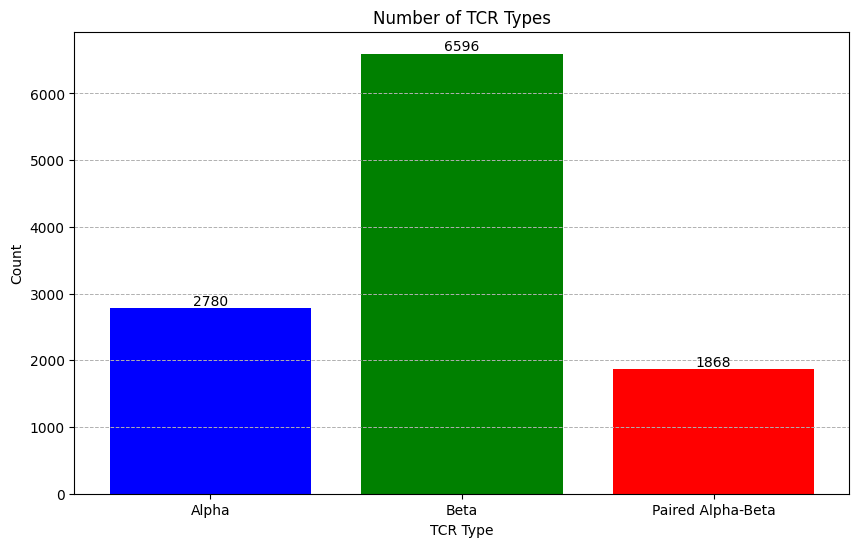

In [126]:
# compariation of data
num_homo_df_alpha = len(homo_df_alpha)
num_homo_df_beta = len(homo_df_beta)
num_homo_df_paired = len(homo_df_paired)

types = ['Alpha', 'Beta', 'Paired Alpha-Beta']
counts = [num_homo_df_alpha, num_homo_df_beta, num_homo_df_paired]
# visualization
plt.figure(figsize=(10, 6))
plt.bar(types, counts, color=['blue', 'green', 'red'])

plt.title('Number of TCR Types')
plt.xlabel('TCR Type')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', linewidth=0.7)
for i in range(len(types)):
    plt.text(i, counts[i], counts[i], ha='center', va='bottom')

plt.show()

# 降维并根据特异性上色
#### 方式：根据tcrdist生成特异性矩阵，再根据epitope上色，看看是否选取的特征和抗原是否有关联性。

In [127]:
# 第一步：引入tcrdist3包 Step 1: Introduce the tcrdist3 package
import pandas as pd
from tcrdist.repertoire import TCRrep

# 第二步：转换格式，将三个人类数据集全部转换为tcrdist3数据包可以识别的格式，主要在于变量名的名字改成包可以识别的形式
# Step 2: Convert the format of the three human datasets into a format that can be recognized by the tcrdist3 package, 
# mainly in the name of the variable name into a form that can be recognized by the package
## α dataset
homo_df_alpha = homo_df_alpha.rename(columns={
    'cdr3': 'cdr3_a_aa',
    'v.segm': 'v_a_gene',
    'j.segm': 'j_a_gene'
})

## β dataset
homo_df_beta = homo_df_beta.rename(columns={
    'cdr3': 'cdr3_b_aa',
    'v.segm': 'v_b_gene',
    'j.segm': 'j_b_gene'
})

## α-β dataset
homo_df_paired = homo_df_paired.rename(columns={
    'CDR3_TRA': 'cdr3_a_aa',
    'CDR3_TRB': 'cdr3_b_aa',
    'Vseg_TRA': 'v_a_gene',
    'Vseg_TRB': 'v_b_gene',
    'Jseg_TRA': 'j_a_gene',
    'Jseg_TRB': 'j_b_gene'
})


### α单链分析(人类)Alpha single chain analysis (human)

In [128]:
# 生成α单链tcr矩阵 Generate the α-single chain tcr matrix
tr = TCRrep(cell_df = homo_df_alpha, 
            organism = 'human', 
            chains = ['alpha'], 
            db_file = 'alphabeta_gammadelta_db.tsv')
alpha_chain_distance_matrix = tr.pw_alpha

c:\Users\15613\AppData\Local\Programs\Python\Python312\Lib\site-packages\tcrdist\repertoire.py:159: UserWarning: cell_df needs a counts column to track clonal number of frequency

  self._validate_cell_df()
c:\Users\15613\AppData\Local\Programs\Python\Python312\Lib\site-packages\tcrdist\repertoire.py:791: UserWarning: No 'count' column provided; count column set to 1
  warnings.warn("No 'count' column provided; count column set to 1")
c:\Users\15613\AppData\Local\Programs\Python\Python312\Lib\site-packages\tcrdist\repertoire.py:833: FutureWarning: The provided callable <function sum at 0x00000206AB1F8360> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  clones = cell_df.groupby(index_cols)['count'].agg(np.sum).reset_index()


### 进行umap降维 Perform umap dimensionality reduction


In [106]:
# 设置umap
reducer = umap.UMAP(metric='precomputed')

# 降维
embedding = reducer.fit_transform(alpha_chain_distance_matrix)

# 可视化
plt.figure(figsize=(10, 7))
plt.scatter(embedding[:, 0], embedding[:, 1], alpha=0.5)
plt.title('UMAP projection of the dataset based on a distance matrix')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.show()

c:\Users\15613\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1857: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


TypeError: 'DataFrame' object is not callable

# β单链分析（人类）Beta single chain analysis (human)

In [ ]:
# 进行β单链分析
df = homo_df_beta[['cdr3_b_aa', 'v_b_gene', 'j_b_gene', 'antigen.epitope']]
df.info()

#生成β单链矩阵
tr = TCRrep(cell_df = df, 
            organism = 'human', 
            chains = ['beta'], 
            db_file = 'alphabeta_gammadelta_db.tsv')

print(tr.pw_beta)

<class 'pandas.core.frame.DataFrame'>
Index: 6596 entries, 1 to 92768
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   cdr3_b_aa        6596 non-null   object
 1   v_b_gene         6596 non-null   object
 2   j_b_gene         6596 non-null   object
 3   antigen.epitope  6596 non-null   object
dtypes: object(4)
memory usage: 257.7+ KB


c:\Users\15613\AppData\Local\Programs\Python\Python312\Lib\site-packages\tcrdist\repertoire.py:159: UserWarning: cell_df needs a counts column to track clonal number of frequency

  self._validate_cell_df()
c:\Users\15613\AppData\Local\Programs\Python\Python312\Lib\site-packages\tcrdist\repertoire.py:791: UserWarning: No 'count' column provided; count column set to 1
  warnings.warn("No 'count' column provided; count column set to 1")
c:\Users\15613\AppData\Local\Programs\Python\Python312\Lib\site-packages\tcrdist\repertoire.py:792: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.cell_df['count'] = 1
c:\Users\15613\AppData\Local\Programs\Python\Python312\Lib\site-packages\tcrdist\repertoire.py:833: FutureWarning: The provided callable <functio

[[  0 170 154 ... 154 150 152]
 [170   0 105 ... 175 135 154]
 [154 105   0 ... 211 145 122]
 ...
 [154 175 211 ...   0 153 189]
 [150 135 145 ... 153   0 142]
 [152 154 122 ... 189 142   0]]


c:\Users\15613\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1857: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


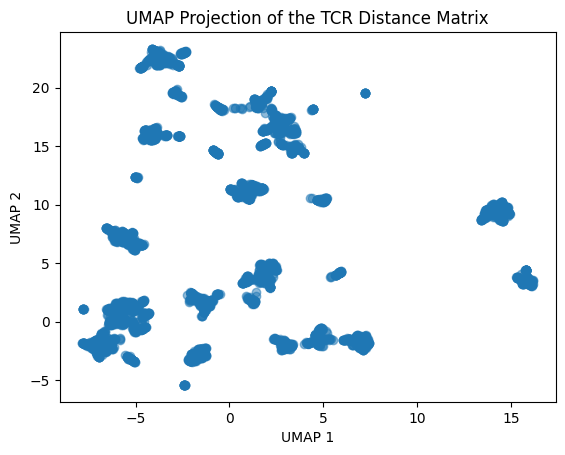

In [ ]:
# 对β链进行umap降维并可视化

human_beta_metrix = tr.pw_beta

reducer = umap.UMAP(
    n_components=2,
    metric='precomputed'
)

embedding = reducer.fit_transform(human_beta_metrix)

plt.scatter(embedding[:, 0], embedding[:, 1], alpha=0.5)
plt.title('UMAP Projection of the TCR Distance Matrix')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

# α-β配对链分析 - 聚合 - 预测
# alpha-beta paired chain analysis - clustering - prediction

In [ ]:
# 进行α-β配对链分析
df = homo_df_paired[['cdr3_a_aa','cdr3_b_aa','v_a_gene','v_b_gene','j_a_gene','j_b_gene']]
df.info()

#生成β单链矩阵
tr = TCRrep(cell_df = df, 
            organism = 'human', 
            chains = ['alpha','beta'], 
            db_file = 'alphabeta_gammadelta_db.tsv')

print("Alpha 链的整体距离:",tr.pw_alpha)
print("Beta 链的整体距离：",tr.pw_beta)
print(tr.pw_cdr3_a_aa)
print(tr.pw_cdr3_b_aa)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1868 entries, 0 to 1867
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   cdr3_a_aa  1868 non-null   object
 1   cdr3_b_aa  1868 non-null   object
 2   v_a_gene   1868 non-null   object
 3   v_b_gene   1868 non-null   object
 4   j_a_gene   1868 non-null   object
 5   j_b_gene   1868 non-null   object
dtypes: object(6)
memory usage: 87.7+ KB


c:\Users\15613\AppData\Local\Programs\Python\Python312\Lib\site-packages\tcrdist\repertoire.py:159: UserWarning: cell_df needs a counts column to track clonal number of frequency

  self._validate_cell_df()
c:\Users\15613\AppData\Local\Programs\Python\Python312\Lib\site-packages\tcrdist\repertoire.py:791: UserWarning: No 'count' column provided; count column set to 1
  warnings.warn("No 'count' column provided; count column set to 1")
c:\Users\15613\AppData\Local\Programs\Python\Python312\Lib\site-packages\tcrdist\repertoire.py:792: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.cell_df['count'] = 1
c:\Users\15613\AppData\Local\Programs\Python\Python312\Lib\site-packages\tcrdist\repertoire.py:833: FutureWarning: The provided callable <functio

[[  0 127 157 ... 168 144 166]
 [127   0 114 ... 138 146 140]
 [157 114   0 ... 126 138 131]
 ...
 [168 138 126 ...   0 162 111]
 [144 146 138 ... 162   0 161]
 [166 140 131 ... 111 161   0]]
[[  0 167 138 ... 147 184 175]
 [167   0 129 ... 117 177 138]
 [138 129   0 ...  84 165 146]
 ...
 [147 117  84 ...   0 168 164]
 [184 177 165 ... 168   0 159]
 [175 138 146 ... 164 159   0]]
[[ 0 24 32 ... 33 28 36]
 [24  0 24 ... 25 30 31]
 [32 24  0 ... 24 25 26]
 ...
 [33 25 24 ...  0 32 19]
 [28 30 25 ... 32  0 35]
 [36 31 26 ... 19 35  0]]
[[ 0 36 28 ... 31 44 39]
 [36  0 28 ... 24 40 36]
 [28 28  0 ... 28 35 34]
 ...
 [31 24 28 ...  0 36 40]
 [44 40 35 ... 36  0 34]
 [39 36 34 ... 40 34  0]]


c:\Users\15613\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1857: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


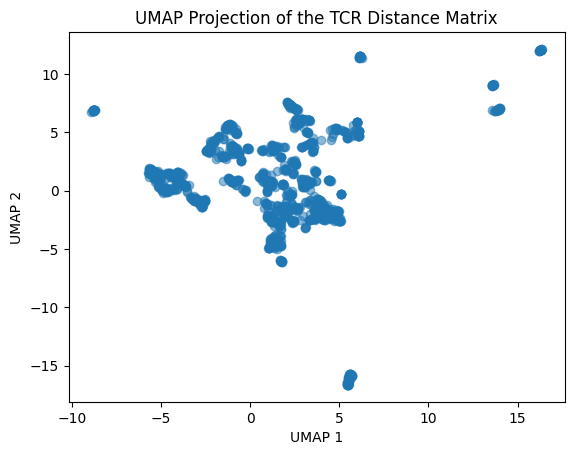

c:\Users\15613\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1857: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


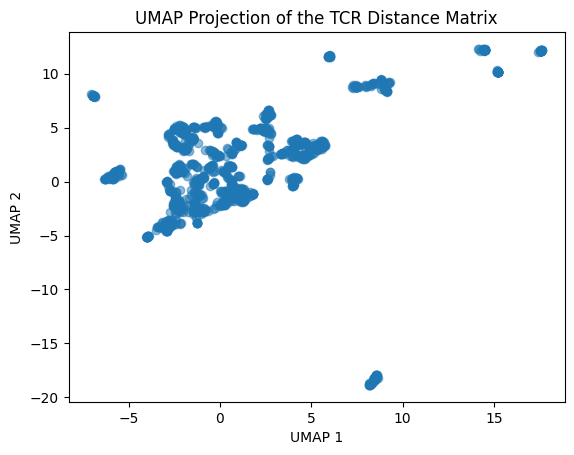

In [ ]:
# 对配对α_β链进行umap降维并可视化
# 针对配对的α链
human_paired_alpha_metrix = tr.pw_alpha

reducer = umap.UMAP(
    n_components=2,
    metric='precomputed'
)

embedding = reducer.fit_transform(human_paired_alpha_metrix)

plt.scatter(embedding[:, 0], embedding[:, 1], alpha=0.5)
plt.title('UMAP Projection of the TCR Distance Matrix')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

# 针对配对的β链
human_paired_alpha_metrix = tr.pw_alpha

reducer = umap.UMAP(
    n_components=2,
    metric='precomputed'
)

embedding = reducer.fit_transform(human_paired_alpha_metrix)

plt.scatter(embedding[:, 0], embedding[:, 1], alpha=0.5)
plt.title('UMAP Projection of the TCR Distance Matrix')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

总结：对于单链α，单链β，配对链α-β，使用umap降维后都有明显的簇。

To summarize: for single-stranded α, single-stranded β, and paired-stranded α-β, there are significant clusters after dimensionality reduction using umap.